<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/03_data_science_modules/03_winter_temperature_enso_SOLUTION.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This notebook examines the relationship between winter minimum temperatures in southern central IN and El Nino.

**Goal:** examine the relationship between El Nino and minimum winter (Dec-Jan-Feb) temperatures in Bloomington, IN

**Method:**

 * obtain minimum temperature data from [NOAA NClimDiv](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00005), using the *NCEI Direct Download* method
 * read the dataset using `pandas`, filter out data for southern central Indiana
 * convert the data to timeseries format
 * obtain the [ENSO longitude index](https://cascade.lbl.gov/enso-longitude-index-eli/) Excel file and read with `pandas`; convert to timeseries format
 * make the ENSO and NClimDiv timeseries align (same start and end dates, same period - DJF, etc)
 * plot both timeseries
 * plot a scatter plot
 * do linear regression and correlation analyses

For this solution notebook, I will be using data directly from NOAA instead of downloading it, since `pandas` has the ability to open data from a URL.

# Part 1: Getting the NClimDiv data

**Important:** Download this notebook and place it in your course folder, running it in Visual Studio Code (not Google Colab).  You'll commit this to your git repository at the end.

In [2]:
""" Import libraries. """
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

According to the [README](https://www.ncei.noaa.gov/pub/data/cirs/climdiv/divisional-readme.txt) file, the first column encodes climate division, variable, and year information, and the remaining 12 columns give data for that month.  The format for the 'code' column is as follows:

```
Element          Record
Name             Position    Element Description

STATE-CODE          1-2      STATE-CODE as indicated in State Code Table as
                             described in FILE 1.  Range of values is 01-91.

DIVISION-NUMBER     3-4      DIVISION NUMBER - Assigned by NCDC.  Range of
                             values 01-10.

ELEMENT CODE        5-6      01 = Precipitation
                             02 = Average Temperature
                             05 = PDSI
                             06 = PHDI
                             07 = ZNDX
                             08 = PMDI
                             25 = Heating Degree Days
                             26 = Cooling Degree Days
                             27 = Maximum Temperature
                             28 = Minimum Temperature
			     71 = 1-month Standardized Precipitation Index
			     72 = 2-month Standardized Precipitation Index
                             73 = 3-month Standardized Precipitation Index
                             74 = 6-month Standardized Precipitation Index
                             75 = 9-month Standardized Precipitation Index
                             76 = 12-month Standardized Precipitation Index
                             77 = 24-month Standardized Precipitation Index

YEAR                7-10     This is the year of record.  Range is 1895 to
                             current year processed.
```

And the state codes are as follows:

```
STATE CODE TABLE: 
                             Range of values of 01-91.

                             01 Alabama                 28 New Jersey
                             02 Arizona                 29 New Mexico
                             03 Arkansas                30 New York
                             04 California              31 North Carolina
                             05 Colorado                32 North Dakota
                             06 Connecticut             33 Ohio
                             07 Delaware                34 Oklahoma
                             08 Florida                 35 Oregon
                             09 Georgia                 36 Pennsylvania
                             10 Idaho                   37 Rhode Island
                             11 Illinois                38 South Carolina
                             12 Indiana                 39 South Dakota
                             13 Iowa                    40 Tennessee
                             14 Kansas                  41 Texas
                             15 Kentucky                42 Utah
                             16 Louisiana               43 Vermont
                             17 Maine                   44 Virginia
                             18 Maryland                45 Washington
                             19 Massachusetts           46 West Virginia
                             20 Michigan                47 Wisconsin
                             21 Minnesota               48 Wyoming
                             22 Mississippi             50 Alaska
                             23 Missouri   
                             24 Montana   
                             25 Nebraska 
                             26 Nevada  
                             27 New Hampshire
```

In [3]:
""" Load the tmin data file. """

climdiv_tminv_url = "https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmindv-v1.0.0-20230804"

# read the NClimDiv data setting -99.99 to NaN
climdiv_tminv = pd.read_csv(climdiv_tminv_url, sep='\s+', header=None, names=['code'] + list(range(1,13)), na_values=-99.9)

climdiv_tminv

,code,1,2,3,4,5,6,7,8,9,10,11,12
0,101281895,27.5,21.8,37.4,47.8,54.7,63.5,66.5,65.9,63.1,37.9,37.4,30.6
1,101281896,30.3,32.6,36.6,52.2,61.1,63.6,68.7,67.1,57.2,44.8,40.1,31.2
2,101281897,26.8,37.4,45.1,47.0,52.4,64.7,68.0,65.2,59.0,48.8,36.5,32.9
3,101281898,34.7,31.0,45.1,42.7,57.4,66.0,68.5,67.1,63.0,47.0,34.5,28.0
4,101281899,28.8,22.2,38.8,47.8,61.2,65.1,66.9,68.3,56.8,50.7,40.3,28.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45658,5013282019,28.7,32.9,29.9,32.3,36.6,43.9,48.0,50.4,46.3,38.4,34.1,27.0
45659,5013282020,18.5,26.0,27.3,33.0,36.9,42.7,47.5,47.3,42.3,37.5,31.6,25.1
45660,5013282021,24.3,30.1,26.8,31.6,36.5,42.2,46.3,47.6,43.3,36.0,25.3,31.1
45661,5013282022,24.2,28.6,26.3,30.4,34.3,42.1,45.3,46.9,44.2,37.3,33.3,29.4


Following the information in the README file, we want statecode 12 and (from looking at other sources) division code 08 for southern central IN.  We can use `pandas` functions to filter out rows that start with code 1208.

In [4]:
""" Isolate the south central IN region """

state_region_code = "1208"

# find rows that start with the state_region_code
scin_rows = climdiv_tminv[climdiv_tminv['code'].astype(str).str.startswith(state_region_code)]

scin_rows

,code,1,2,3,4,5,6,7,8,9,10,11,12
10707,1208281895,14.5,11.1,28.5,42.8,50.1,61.6,61.8,62.1,56.9,33.6,31.6,25.8
10708,1208281896,22.8,23.5,26.5,47.8,56.6,59.7,64.9,62.1,52.8,37.7,34.4,27.0
10709,1208281897,17.8,25.4,33.3,40.8,45.1,58.4,65.6,60.3,53.6,45.3,32.6,25.8
10710,1208281898,26.0,23.8,36.2,38.8,53.1,61.5,64.9,63.9,58.8,45.0,28.8,20.6
10711,1208281899,20.7,12.7,29.4,43.9,55.1,62.8,63.0,64.4,53.1,46.5,36.1,21.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10831,1208282019,22.8,27.4,29.6,42.8,55.4,60.0,65.6,62.3,59.6,44.9,28.0,29.4
10832,1208282020,29.3,27.6,38.2,39.1,50.2,60.3,66.3,62.1,54.3,43.4,36.4,26.4
10833,1208282021,25.4,19.6,35.6,41.0,49.0,62.2,64.7,65.0,57.2,51.3,29.4,33.3
10834,1208282022,17.5,22.9,34.1,40.7,54.5,60.3,66.4,62.9,54.9,39.9,33.5,26.1


Okay, now we have 129 rows, ranging from the year 1895 up to 2023, and I see missing values for the last months of 2023 (Aug-Dec) as expected given that those months don't yet have data.

Now we want to create a vector timeseries out of this.  We can access the underlying `numpy` array and use `ravel()` to do so.

In [5]:
""" Extract a vector of the data values. """
# convert the data to a numpy array
scin_data_np = scin_rows.values
print(f"scin_data_np.shape = {scin_data_np.shape}")

# remove the first column (the code column)
scin_data_np = scin_data_np[:,1:]

# ravel the data
scin_data = scin_data_np.ravel()
scin_data

scin_data_np.shape = (129, 13)


array([14.5, 11.1, 28.5, ...,  nan,  nan,  nan])

Now that we have the vector, we want to create a vector of the corresponding dates.  We can use `date_range` to do this.

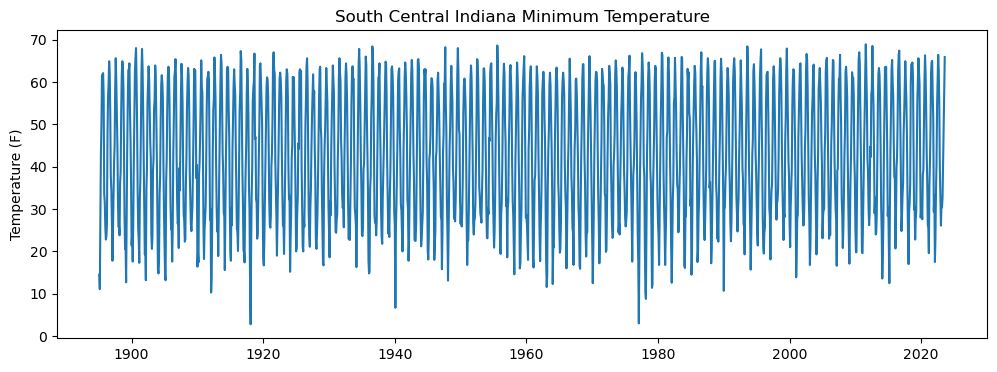

In [6]:
""" Create dates and plot the data. """
scin_dates = pd.date_range(start='1895-01-01', end='2023-12-31', freq='M')

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(scin_dates, scin_data)
ax.set_title("South Central Indiana Minimum Temperature")
ax.set_ylabel("Temperature (F)")
plt.show()



Now that we have the timeseries, we can use pandas to calculate the DJF averages.

C:\Users\travi\AppData\Local\Temp\ipykernel_13540\2244496911.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  scin_djf_avg = scin_djf_df.groupby(scin_djf_df['date'].dt.year).mean()


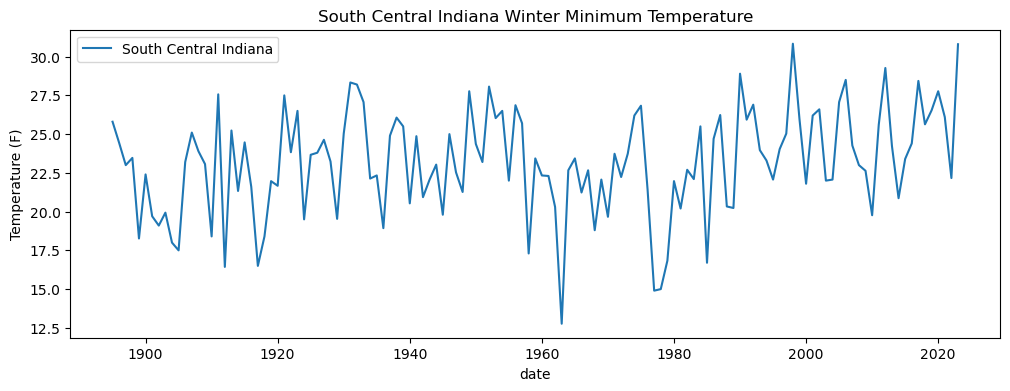

In [7]:
""" Calculate winter (DJF) averages. """

# create a new pandas dataframe with the dates and data
scin_df = pd.DataFrame({'date': scin_dates, 'South Central Indiana': scin_data})

# extract only DJF data
scin_djf_df = scin_df[scin_df['date'].dt.month.isin([12,1,2])]

# omit the first two steps of the first year and the last step of the last year since they are incomplete seasons
scin_djf_df = scin_djf_df.iloc[2:-1]

# group by year and average
scin_djf_avg = scin_djf_df.groupby(scin_djf_df['date'].dt.year).mean()

# plot the data
fig, ax = plt.subplots(figsize=(12,4))
scin_djf_avg.plot(ax = ax)
ax.set_title("South Central Indiana Winter Minimum Temperature")
ax.set_ylabel("Temperature (F)")
plt.show()



# Part 2: Getting the ELI data

In [8]:
""" Get the ENSO data. """
eli_url = "https://portal.nersc.gov/archive/home/projects/cascade/www/ELI/ELI_ERSSTv5_1854.01-2020.05.xlsx"

# read the data (note, I had to install the openpyxl package to read this file)
eli_df = pd.read_excel(eli_url, sheet_name='ELI_ERSSTv5_1854.01-2020.02', header=0, index_col=0, parse_dates=True)
eli_df

,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Jan,158.62,156.95,163.24,151.52,164.42,158.76,156.20,159.05,155.27,158.75,...,150.93,152.95,155.70,157.64,160.75,175.10,155.08,154.20,160.23,158.67
Feb,159.30,159.96,158.84,154.36,167.38,154.50,153.08,178.75,156.26,178.35,...,150.42,153.97,154.62,157.65,160.22,172.86,156.50,154.15,163.96,158.26
Mar,154.63,155.97,158.07,150.68,154.81,157.37,161.36,172.58,159.08,166.54,...,146.19,153.88,147.89,158.11,161.58,164.78,158.90,151.16,161.35,155.82
Apr,154.60,154.78,150.77,147.31,162.29,154.51,152.08,151.74,151.58,154.86,...,146.99,158.13,148.63,154.01,164.81,155.91,156.11,152.29,157.37,152.13
May,160.56,159.68,157.31,157.18,163.30,155.67,155.39,153.93,154.05,153.56,...,148.74,151.82,157.76,157.77,167.87,160.95,157.20,157.35,161.7,154.51
Jun,167.42,164.79,160.78,175.59,166.08,159.56,168.50,158.09,161.82,158.75,...,160.46,163.68,163.07,168.99,179.12,162.99,166.31,163.56,169.81,NaN
Jul,171.27,169.29,164.36,170.79,168.07,172.13,174.46,162.12,163.93,175.96,...,165.15,171.93,165.38,172.30,182.31,162.86,167.77,167.36,170.99,NaN
Aug,170.06,164.72,162.23,168.05,165.31,171.72,168.99,168.20,167.53,169.20,...,163.99,170.16,165.98,170.86,182.46,160.89,165.69,167.66,169.55,NaN
Sep,167.25,170.77,157.28,171.20,163.19,166.94,160.77,167.22,172.79,165.32,...,162.47,167.07,164.86,168.46,181.57,159.52,165.12,165.77,167.04,NaN
Oct,162.51,171.23,163.08,167.59,163.84,165.18,157.49,158.13,169.94,160.51,...,158.79,164.63,161.79,164.21,179.94,156.15,161.67,165.35,164.16,NaN


That was easy - but this data has a similar problem to the NClimDiv dataset - the data are in a table, but we want a timeseries.  We can extract the numpy values, transpose, and ravel.

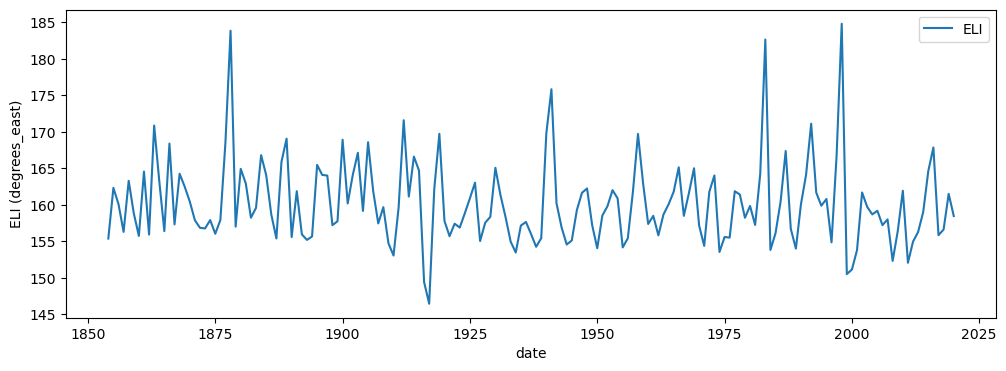

In [9]:
""" Create an ELI timeseries. """

# create a timeseries from the data
eli_data_np = eli_df.T.values.ravel()

# create dates corresponding to the data
eli_dates = pd.date_range(start='1854-01-01', end='2021-01-01', freq='M')

# put this back into a data frame
eli_ts_df = pd.DataFrame({'date': eli_dates, 'ELI': eli_data_np})

# calculate the DJF average
eli_djf_df = eli_ts_df[eli_ts_df['date'].dt.month.isin([12,1,2])]

# omit the first two steps of the first year and the last step of the last year since they are incomplete seasons
eli_djf_df = eli_djf_df.iloc[2:-1]

# group by year and average
eli_djf_avg = eli_djf_df.groupby(eli_djf_df['date'].dt.year).mean().drop('date', axis=1)

# plot the data
fig, ax = plt.subplots(figsize=(12,4))
eli_djf_avg.plot(ax = ax)
ax.set_ylabel("ELI (degrees_east)")
plt.show()


Now that we have timeseries for both datasets, all that's left is to combine them.  Pandas makes that easy with the `merge()` method.

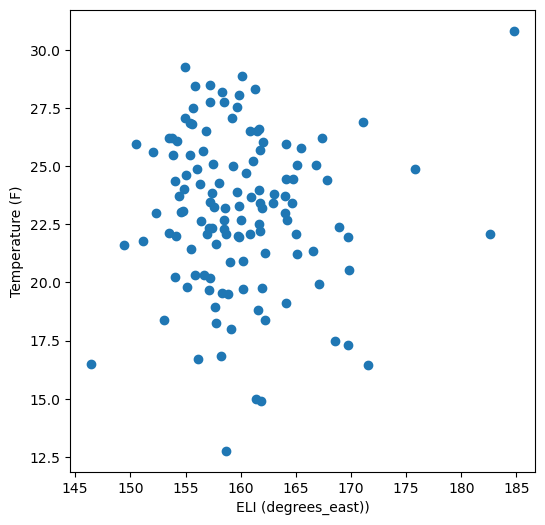

In [10]:
""" Combine the two datasets. """
# merge the two dataframes
scin_eli_df = pd.merge(scin_djf_avg, eli_djf_avg, left_index=True, right_index=True)

# plot a scatter plot
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(scin_eli_df['ELI'], scin_eli_df['South Central Indiana'])
ax.set_xlabel("ELI (degrees_east))")
ax.set_ylabel("Temperature (F)")
plt.show()


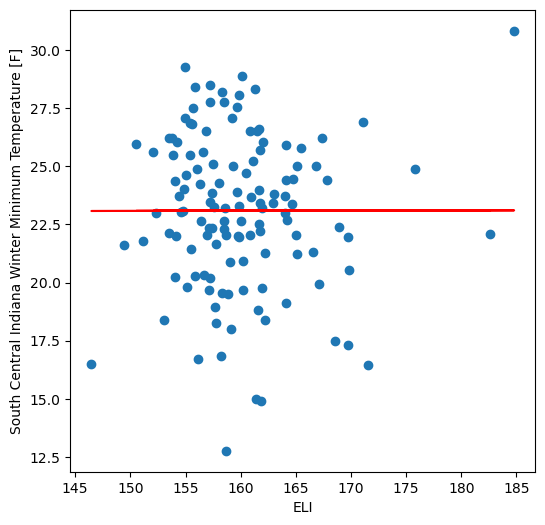

In [11]:
""" Calculate the correlation coefficient and regression line. """

# calculate the correlation coefficient
corr_matrix = scin_eli_df.corr()
corr = corr_matrix.iloc[0,1]

# calculate the regression line using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(scin_eli_df['ELI'], scin_eli_df['South Central Indiana'])
m = slope
b = intercept

# plot the data with the regression line
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(scin_eli_df['ELI'], scin_eli_df['South Central Indiana'])
ax.plot(scin_eli_df['ELI'], m * scin_eli_df['ELI'] + b, color='red')
ax.set_xlabel("ELI")
ax.set_ylabel("South Central Indiana Winter Minimum Temperature [F]")
plt.show()


Based on visual inspection, based on a small correlation coefficient (close to 0.001!), and based on a nearly-zero regression slope, I conclude that El Nino has very little impact on minimum temperatures in the South Central Indiana region.  So it appears that a prediction based on ELI might not be possible.